# Bibliotecas que vamos a usar para nuestro modelo de clasificación

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D


2024-06-05 02:49:56.698889: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-05 02:49:56.699064: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-05 02:49:56.882036: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Ahora lo que tenemos que hacer es importar el conjunto de datos. En este caso trabajaremos la clasificación con un conjunto de datos sobre alzheimer.Tenemos 4 clases
* 1. Mild demented
* 2. Moderate Demented
* 3. Non Demented
* 4. Very Mild Demented

In [2]:
#conjunto de datos para entrenar el modelo
train_data = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train'
#conjunto de datos para probar el modelo
test_data = '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test'

Ahora con la fucnión **ImageDataGenerator** de keras, lo que haremos sera normalizar nuestros datos en una escala de 0 a 1. Tambén redimensionaremos las dimensiones de nuestras imagenes para que todas tengan la misma dimension. Dado que estamos trabajando con radiografias, lo mejor sería tener una resolución con la que podamos ver los detalles más finos de la radiografia y poder detectar qué tan avanzado está el Alzheimer.

In [3]:
#parametros de ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255) # normalización de pixeles
#Generadores de datos para entrenamiento y validación
train_generator = datagen.flow_from_directory(
    train_data,
    target_size=(224,224), # tamaño de las dimensiones de nuestras imagenes
    batch_size=16, # lote de imagens que se le pasaran al modelo en cada entrenamiento
    class_mode='categorical', # 4 clases
    color_mode='grayscale',
    shuffle=True # controlamos si las imagenes se mezclan aleatoriamente
)
# Generador de datos para probar el modelo (sin aumnetar datos)
test_generator = datagen.flow_from_directory(
    test_data,
    target_size=(224,224), # tamaño de las dimensiones de nuestras imagenes
    batch_size=16, # lote de imagens que se le pasaran al modelo en cada entrenamiento
    class_mode='categorical', # 4 clases
    color_mode='grayscale',
    shuffle=False # controlamos si las imagenes se mezclan aleatoriamente
)

Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [4]:
print("Imágenes de entrenamiento:", train_generator.samples)
print("Dimensiones de entrenamiento:", train_generator.image_shape)
print("Imágenes de prueba:", test_generator.samples)
print("Dimensiones de prueba:", test_generator.image_shape)

Imágenes de entrenamiento: 5121
Dimensiones de entrenamiento: (224, 224, 1)
Imágenes de prueba: 1279
Dimensiones de prueba: (224, 224, 1)


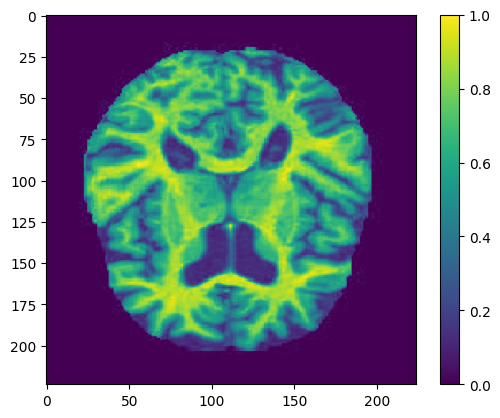

In [5]:
# veamos una radiografia de nuestro conjunot de imagenes
images, labels = train_generator[0]
#mostramos la primera imagen del  lote
plt.figure()
plt.imshow(images[0])
plt.colorbar()
plt.grid(False)
plt.show()

Pensandolo bien, también nos gustaria visualizar en la imagen la clase a la que pertenece la radiografia

In [6]:
class_names = ['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented']

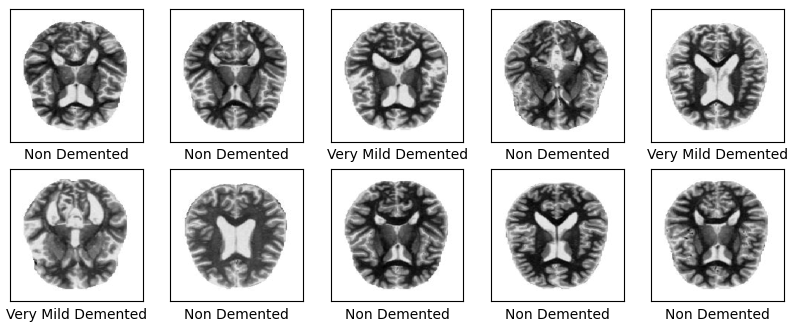

In [7]:
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap=plt.cm.binary)
    # utilizamos np.argmax() para obtener el indice del valor más grande
    # en este caso los labels son de la forma [0,1,0,0] y la pasar argmax([0,1,0,0])
    # lo que obtendremos es que el indice 1 tiene el valor maximo, es decir que estamos
    # obteniendo la clase a la que pertenece la radiografia
    predict_class_index = np.argmax(labels[i])
    # ya que tenemos el indice o la clase de la radografia la pasamos
    # en nuestra lista class_names y obtenemos el diagnostico de la radiografia
    predict_class_name = class_names[predict_class_index]
    plt.xlabel(predict_class_name)
plt.show()

# Contruyendo el modelo

En esta parte ya empezaremos con la contrucción del modelo de nuestra red neuronal. Vamos a espceificar las capas, fucniones de activación, etc.

## Configuración de las capas

In [8]:
from tensorflow.keras.layers import Input

In [9]:
model = keras.Sequential([
    Input(shape=(224,224,1)), #aceptamos 1 canal de color
    keras.layers.Conv2D(32, (3,3), activation='relu'),
    keras.layers.GlobalMaxPool2D(),
    keras.layers.Flatten(input_shape=(224,224)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(4, activation='softmax')
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Compilación del modelo

In [10]:
model.compile(
    optimizer='nadam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [11]:
model.fit(train_generator, epochs = 10, steps_per_epoch = 313)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


313/313 ━━━━━━━━━━━━━━━━━━━━ 73s 225ms/step - accuracy: 0.4754 - loss: 1.1082
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3681 - loss: 1.0684    
Epoch 3/10


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


313/313 ━━━━━━━━━━━━━━━━━━━━ 71s 226ms/step - accuracy: 0.4741 - loss: 1.0363
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4696 - loss: 1.0922    
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 70s 223ms/step - accuracy: 0.4972 - loss: 1.0384
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5468 - loss: 1.0625    
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 70s 223ms/step - accuracy: 0.4939 - loss: 1.0270
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4826 - loss: 1.1029    
Epoch 9/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 70s 224ms/step - accuracy: 0.5094 - loss: 1.0167
Epoch 10/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5008 - loss: 0.9525    


## Evaluamos la exactitud

In [12]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print('\nTest accuracy:', test_acc)

80/80 - 8s - 99ms/step - accuracy: 0.5356 - loss: 1.0194

Test accuracy: 0.5355746746063232


Hace falta mejorar el modelo....